# Final Project DL model Notebook - single hidden layer model - v01

#### imports, settings and constants

In [1]:
import sys

from keras.models import Sequential
from keras.layers import BatchNormalization, Flatten, Dense
from keras.optimizers import Adam
import numpy as np

from pathlib import Path

sys.path.append(str(Path.cwd().parent))
from utils import *

current_dir = Path.cwd()
HOME_DIR = current_dir.parent
DATA_DIR = HOME_DIR.joinpath('data')

# comment out one of the two path options to toggle between sample directory and all data
# path = DATA_HOME_DIR
path = DATA_DIR.joinpath('sample')
train_path = path.joinpath('train')
val_path = path.joinpath('valid')
test_path = path.joinpath('test')
results_path = path.joinpath('tesults')

# training variables
batch_size = 16
epochs = 2
learning_rate = 1e-3

Using Theano backend.


#### getting training and validation data in batches

In [2]:
batches = get_in_batches(train_path, batch_size=batch_size)
val_batches = get_in_batches(val_path, batch_size=batch_size)
test_batches = get_in_batches(test_path, batch_size=batch_size)

Found 1000 images belonging to 10 classes.
Found 200 images belonging to 10 classes.
Found 0 images belonging to 0 classes.


#### and getting the classes, labels and filenames for each batch

In [3]:
trn_classes = batches.classes
val_classes = val_batches.classes
trn_labels = onehot(batches.classes)
val_labels = onehot(val_batches.classes)
trn_filenames = batches.filenames
val_filenames = val_batches.filenames

#### defining linear model

In [4]:
model = Sequential([
        BatchNormalization(axis=1, input_shape=(3,224,224)),
        Flatten(),
        Dense(100, activation='relu'),
        BatchNormalization(),
        Dense(10, activation='softmax')
    ])
model.compile(Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 3, 224, 224)       12        
_________________________________________________________________
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               15052900  
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 15,054,322
Trainable params: 15,054,116
Non-trainable params: 206
_________________________________________________________________


#### fit_generator() consuming the batches provided by the ImageDataGenerator to fit the model to the data

In [5]:
history = model.fit_generator(batches,
                    steps_per_epoch=batches.batch_size,
                    validation_data=val_batches,
                    validation_steps=val_batches.batch_size,
                    epochs=epochs)

Epoch 1/2
16/16 [==============================] - 11s - loss: 3.0576 - acc: 0.1172 - val_loss: 13.9751 - val_acc: 0.1210
Epoch 2/2
16/16 [==============================] - 9s - loss: 2.4943 - acc: 0.1719 - val_loss: 12.2731 - val_acc: 0.1250


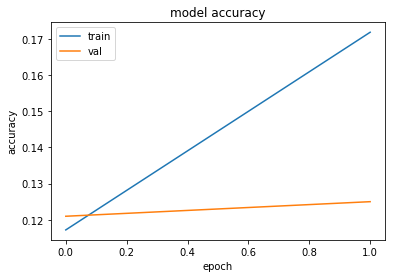

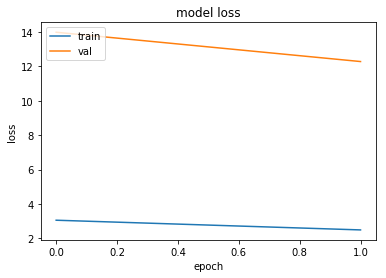

In [6]:
plot_acc_and_loss(history)

#### validating the model performance on the val set

In [7]:
rnd_batches = get_in_batches(val_path, batch_size=batch_size*2, shuffle=True)
val_res = [model.evaluate_generator(rnd_batches, rnd_batches.samples) for i in range(epochs)]
np.round(val_res, 3)

Found 200 images belonging to 10 classes.


array([[ 12.267,   0.115],
       [ 12.27 ,   0.115]])

#### test performance and plot confusion matrix on one batch of 200 images

In [8]:
test_set = get_in_batches(val_path, shuffle=False, class_mode=None, batch_size=200)
pred_classes = model.predict_generator(test_set, 1)
pred_classes = np.argmax(pred_classes, axis=1)
act_classes = test_set.classes

Found 200 images belonging to 10 classes.


[[ 0  7  0  0  8  0  0  3  0  2]
 [ 1  5  0  0 13  0  0  1  0  0]
 [ 2  4  0  0 10  0  0  4  0  0]
 [ 0  1  0  0 19  0  0  0  0  0]
 [ 3  1  0  0 13  0  0  3  0  0]
 [ 1  0  0  0 16  0  0  3  0  0]
 [ 0  3  0  0 15  0  0  2  0  0]
 [ 0  1  0  0 13  0  1  5  0  0]
 [ 1  3  0  0 13  0  0  3  0  0]
 [ 1  4  0  0 12  0  0  2  1  0]]


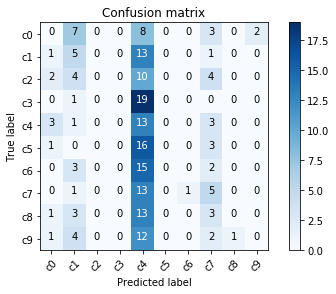

In [9]:
cm = confusion_matrix(act_classes, pred_classes)
plot_confusion_matrix(cm, val_batches.class_indices)
plt.figure()
plt.show()